<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/entropy.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(entropy_notebook)=
# Entropia

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Generalizzabilità dei modelli e fondamenti del metodo scientifico

Uno degli aspetti più cruciali dei modelli scientifici è la loro capacità di generalizzarsi. La generalizzabilità non è soltanto un attributo desiderabile di un buon modello, ma costituisce anche uno dei pilastri fondamentali del metodo scientifico. Se i risultati di uno studio o di un modello non possono essere applicati a contesti più ampi, il valore scientifico di un tale lavoro rischia di essere significativamente limitato.

### La Replicabilità: Il Punto di Partenza Fondamentale

Nel contesto del metodo scientifico, la replicabilità è spesso vista come un requisito essenziale, una sorta di "biglietto d'ingresso" alla discussione scientifica. I risultati che non possono essere replicati sono difficilmente considerati validi. Tuttavia, è essenziale riconoscere che la replicabilità, pur necessaria, non è di per sé sufficiente. Un modello può essere replicabile ma non generalizzabile, il che significa che i suoi risultati potrebbero non essere applicabili al di fuori del contesto specifico in cui è stato testato.

### Tre Domande Fondamentali per la Robustezza dei Modelli

Secondo {cite:t}`Johnson2022bayesrules`, ci sono tre domande chiave da porsi per valutare la robustezza di un modello: Quali sono le implicazioni delle nostre inferenze? Le assunzioni del modello sono valide? Quanto accuratamente il modello può fare previsioni? Quest'ultima domanda è particolarmente cruciale quando si parla di generalizzabilità. In altre parole, un modello che riesce a fare previsioni accurate su nuovi dati supera un test fondamentale della sua utilità scientifica.

### Sfide e Soluzioni: Sovra-Adattamento e Sotto-Adattamento

Una delle principali sfide nella creazione di modelli generalizzabili è evitare le trappole del sovra-adattamento e del sotto-adattamento, come descritto in {cite:p}`McElreath_rethinking`.  Il sovra-adattamento si verifica quando i modelli sono troppo specifici e quindi inutili al di fuori del set di dati su cui sono stati addestrati. Al contrario, il sotto-adattamento si verifica quando i modelli sono troppo generali per essere utili anche nel contesto specifico per cui sono stati creati. Qui, l'approccio bayesiano offre una soluzione elegante, concentrandosi sulla capacità predittiva del modello su nuovi set di dati.

### Equilibrio nella Selezione dei Modelli: Semplicità e Precisione

Nella selezione dei modelli, oltre all'approccio bayesiano, è importante considerare principi come il rasoio di Ockham, che suggerisce di privilegiare la semplicità ove possibile. Tuttavia, questa semplicità non deve compromettere la capacità del modello di descrivere accuratamente i dati. Anche i test di ipotesi, nonostante le critiche per l'enfasi sui valori-p, rimangono uno strumento comune, ma devono essere utilizzati con attenzione per evitare errori di sovra-adattamento e sotto-adattamento.

### Obiettività nella Misurazione: Entropia e Divergenza di Kullback-Leibler

Nel confronto tra modelli alternativi, emerge spesso la necessità di misurare quanto un modello si avvicini al "vero" processo generativo dei dati. La divergenza di Kullback-Leibler è una metrica popolare in questo contesto, usata per quantificare questa "vicinanza".

### Selezione di Modelli e Entropia

Nella sfida di selezionare il modello più aderente al "vero" processo generativo dei dati, cerchiamo un modo per quantificare la "vicinanza" del modello alla distribuzione sottostante dei dati. Questa vicinanza va intesa non solo in termini della famiglia di distribuzioni (ad esempio, normale contro Gamma), ma anche in termini dei parametri specifici che caratterizzano queste distribuzioni. La divergenza di Kullback-Leibler (KL) è un indice spesso utilizzato per affrontare questa sfida in modo quantitativo. Tuttavia, per comprendere appieno questa metrica, è essenziale introdurre prima il concetto di entropia.

#### Entropia: Una Misura dell'Incertezza

Nel campo dell'informatica e della teoria delle probabilità, il concetto di entropia, sviluppato da Claude Shannon durante il suo lavoro presso i Bell Labs, gioca un ruolo cruciale nel misurare l'incertezza o la "sorpresa" associata all'osservazione di un evento. Nella creazione di una metrica per misurare questa incertezza, Shannon propose tre requisiti intuitivi: continuità, aumento con la lunghezza del messaggio e additività. Questi criteri sono univocamente soddisfatti dalla cosiddetta entropia dell'informazione.

L'entropia dell'informazione di Shannon quantifica il contenuto informativo in un messaggio o, inversamente, l'estensione della riduzione dell'incertezza iniziale dopo aver ricevuto il messaggio. Ad esempio, consideriamo l'evento di scoprire che un evento con probabilità $ p $ si è verificato. La "sorpresa" di questa scoperta è quantificata da $ -\log_2(p) $, espressa in bit. Eventi rari, con bassa probabilità, generano un alto livello di sorpresa, mentre eventi certi (probabilità 1) non generano alcuna sorpresa. Il logaritmo in base 2 è utilizzato perché in informatica un bit rappresenta l'unità fondamentale di informazione, equivalente a una scelta binaria tra due esiti equiprobabili.

Nell'esempio di due eventi indipendenti $ A $ e $ B $, la sorpresa totale nell'osservare entrambi gli eventi $ A \cap B $ è la somma delle sorprese individuali, grazie alla proprietà additiva dei logaritmi.

Se consideriamo $ X $ come una variabile casuale discreta con possibili valori distinti $ a_1, a_2, \ldots, a_n $ e probabilità associate $ p_1, p_2, \ldots, p_n $ (la cui somma è 1), l'entropia di $ X $ si definisce come la media ponderata della sorpresa per ogni possibile esito di $ X $:

$$
H(X) = -\sum_{x} p(x) \log_2 p(x),
$$

dove la somma si estende a tutti gli esiti di $ X $. Da notare che l'entropia dipende unicamente dalle probabilità $p_j$ e non dai valori specifici $a_j$. Questa misura rappresenta la quantità media di informazione o sorpresa attesa dall'osservazione di $ X $.

Per variabili continue, il concetto di entropia si generalizza come:

$$
H(X) = -\int p(x) \log_2 p(x) \, dx,
$$

dove l'integrazione copre tutti i possibili esiti di $ X $. 

L'entropia raggiunge il suo massimo in condizioni di completa incertezza, ovvero quando tutti gli esiti di $ X $ sono equiprobabili, indicando la massima variabilità o imprevedibilità nei dati. Al contrario, l'entropia si riduce al minimo (vale zero) quando l'esito è completamente prevedibile, come nel caso di un evento con certezza assoluta. Questo concetto è fondamentale nella teoria dell'informazione, fornendo un quadro quantitativo per valutare e gestire l'incertezza nei dati.

#### Divergenza di Kullback-Leibler: Un Strumento per Confrontare le Distribuzioni

Dopo aver discusso il concetto di entropia di Shannon, che misura l'incertezza o la sorpresa associata all'osservazione di un evento, possiamo esplorare la Divergenza di Kullback-Leibler (KL), derivata da Kullback e Leibler nel 1951. Questa misura, che si rivela essere l'opposto negativo dell'entropia dell'informazione di Shannon, è fondamentale per quantificare le differenze tra due distribuzioni di probabilità.

La divergenza KL tra due distribuzioni, $P$ e $Q$, relative alla stessa variabile aleatoria $X$, viene calcolata in modi differenti a seconda che le distribuzioni siano discrete o continue. Per le distribuzioni discrete, la divergenza KL si esprime come:

$$
D_{KL}(P \parallel Q) = \sum_x p(x) \log \left(\frac{p(x)}{q(x)}\right),
$$

Mentre per le distribuzioni continue, si ha:

$$
D_{KL}(P \parallel Q) = \int p(x) \log \left(\frac{p(x)}{q(x)}\right) \, dx.
$$

Questa misura, essendo sempre non negativa, rappresenta la quantità di informazione "persa" quando si utilizza la distribuzione $Q$ per approssimare la distribuzione $P$. 

La Divergenza KL può essere interpretata anche in termini di entropia. Si può esprimere come la differenza tra l'entropia incrociata $H(P, Q)$ e l'entropia $H(P)$ di $P$. L'entropia di $P$ è definita come:

$$
H(P) = -\sum_x p(x) \log(p(x)),
$$

e l'entropia incrociata tra $P$ e $Q$ è:

$$
H(P, Q) = -\sum_x p(x) \log(q(x)).
$$

In questo quadro, l'entropia $H(P)$ misura l'incertezza intrinseca nella distribuzione $P$. L'entropia incrociata $H(P, Q)$, invece, quantifica l'incertezza risultante dall'uso di $Q$ per approssimare $P$. Di conseguenza, la divergenza KL rivela la differenza tra la sorpresa media che sperimentiamo utilizzando le probabilità reali $p$, ma basandoci su $q$ (ad esempio, quando $p$ è sconosciuta e $q$ rappresenta la nostra stima) e la sorpresa media quando operiamo con le probabilità $p$. In pratica, la Divergenza KL fornisce una misura quantitativa dell'errore o della discrepanza introdotta nell'approssimare una distribuzione di probabilità con un'altra.

Nella pratica, la divergenza KL è spesso impiegata come criterio per la selezione di modelli. L'obiettivo è trovare un modello $Q$ che minimizzi $D_{KL}(P \parallel Q)$, o equivalentemente, minimizzi la differenza $H(P, Q) - H(P)$.

È importante sottolineare che la divergenza KL è non negativa e assume valore zero se e solo se $P$ e $Q$ sono identiche. Inoltre, la divergenza KL non è simmetrica, cioè $D_{KL}(P \parallel Q) \neq D_{KL}(Q \parallel P)$.

In conclusione, la divergenza di Kullback-Leibler offre un metodo quantitativo per valutare quanto una distribuzione $Q$ sia un'efficace approssimazione di un'altra distribuzione $P$, considerando le incertezze intrinseche a entrambe le distribuzioni.

#### Applicazione nella Selezione di Modelli

Uno degli obiettivi chiave nella selezione di modelli statistici è identificare il modello $Q$ che minimizza la divergenza di Kullback-Leibler (KL) rispetto alla distribuzione "vera" $P$ dei dati. Tuttavia, nella realtà pratica, la distribuzione $P$ è spesso sconosciuta e non direttamente osservabile. Pertanto, si ricorre a criteri approssimativi come il Criterio di Informazione di Akaike (AIC) o il Criterio di Informazione Bayesiano (BIC). Questi criteri forniscono stime surrogate per la minimizzazione della divergenza KL, permettendo una valutazione indiretta dell'adeguatezza del modello.

## Esempi concreti per l'Entropia

Per comprendere meglio il concetto di entropia, esaminiamo alcuni esempi pratici.

### L'Entropia di un Singolo Evento

Prendiamo in considerazione il lancio di una moneta equilibrata. In questo caso, la probabilità di ottenere testa (così come croce) è di 0.5. La quantità di informazione, o sorpresa, risultante dall'ottenimento di "testa" in un tale esperimento è calcolata mediante la formula dell'entropia:

$$
H(\text{Testa}) = -\log_2(0.5).
$$

In [4]:
-np.log2(0.5)

1.0

Calcolando il logaritmo in base 2 di 0.5, otteniamo un valore di 1 bit. Questo significa che, in termini di entropia, ogni risultato del lancio di una moneta (sia testa che croce) contribuisce con un bit di informazione. Questo riflette l'incertezza massima in un processo con due esiti equiprobabili: ogni lancio di una moneta equilibrata è completamente imprevedibile e, di conseguenza, fornisce la massima quantità di informazione possibile.

In questo contesto, dove tutti gli esiti sono equiprobabili, l'entropia raggiunge il suo valore massimo, indicando un'incertezza totale sul risultato prima del lancio. La sorpresa, o informazione acquisita, osservando il risultato è quindi massima. 

Al contrario, se consideriamo un evento con una probabilità di 1 (per esempio, una moneta truccata che produce sempre "Testa"), l'entropia è $ H(p = 1) = 0 $. Questo implica che l'osservazione dell'esito "Testa" non fornisce alcuna informazione aggiuntiva, in quanto l'evento è prevedibile con certezza.

Se si effettuano $ n $ lanci di una moneta equilibrata, ogni lancio contribuisce con 1 bit all'informazione totale. Pertanto, una sequenza di $ n $ lanci richiede $ n $ bit di informazione per essere descritta completamente.

Consideriamo ora una moneta sbilanciata, dove la probabilità di ottenere "Testa" è solo del 10% (0.1). In questo caso, l'evento "Testa" diventa più raro e, quindi, sorprendente quando si verifica. L'entropia per l'evento "Testa" in questa situazione è calcolata come:

$$
H(\text{Testa}) = -\log_2(0.1).
$$

Calcolando questo logaritmo, otteniamo un valore superiore a 3 bit. 

In [5]:
-np.log2(0.1)

3.321928094887362

Questo significa che l'informazione necessaria per rappresentare adeguatamente l'evento "Testa" in una moneta sbilanciata è maggiore rispetto a una moneta equilibrata. La maggiore rarità dell'evento aumenta la sorpresa e, di conseguenza, l'informazione associata alla sua osservazione.

Consideriamo ora il caso di un dado a sei facce e concentriamoci sull'evento "uscita del numero 6". La probabilità di questo evento è di 1/6, inferiore rispetto alla probabilità di 1/2 di ottenere "testa" con un lancio di moneta. Conseguentemente, ci aspettiamo che l'evento "uscita del numero 6" generi una sorpresa maggiore rispetto all'evento "testa" in un lancio di moneta. 

Per quantificare l'informazione associata all'evento "uscita del numero 6", possiamo utilizzare la formula dell'informazione di Shannon:

$$
-\log_2\left(\frac{1}{6}\right) \approx 2.58 \text{ bit}.
$$

In [6]:
-np.log2(1/6)

2.584962500721156

Questo calcolo mostra che l'informazione associata all'uscita del numero 6 è di circa 2.58 bit, significativamente superiore all'informazione di 1 bit per l'evento "testa". In pratica, ciò significa che l'evento legato al dado è più "sorprendente" e porta con sé più informazione rispetto all'evento del lancio di moneta.

### Informazione di Shannon e Entropia: Differenze e Relazioni

L'informazione di Shannon e l'entropia sono due concetti strettamente correlati ma con alcune distinzioni chiave. La principale differenza tra i due concetti è che l'informazione di Shannon si concentra su un singolo evento, mentre l'entropia considera la distribuzione di probabilità complessiva di una variabile aleatoria.

L'informazione di Shannon $ I(x) $ è definita come la quantità di informazione contenuta in un singolo evento $ x $, in base alla sua probabilità $ p(x) $. La formula è:

$$
I(x) = -\log_{2}(p(x)).
$$

L'informazione è tanto maggiore quanto più bassa è la probabilità dell'evento (ovvero, gli eventi rari sono più "sorprendenti") e diminuisce all'aumentare della probabilità dell'evento.

D'altro canto, l'entropia $ H(X) $ rappresenta l'incertezza media associata a una variabile aleatoria $ X $, considerando la sua distribuzione di probabilità $ p(x) $. Viene calcolata come l'aspettazione matematica dell'informazione di Shannon per tutti i possibili esiti $ x $ di $ X $:

$$
H(X) = \mathbb{E}[I(X)] = -\sum_{x \in X} p(x) \log_{2}(p(x)).
$$

In questo modo, l'entropia rappresenta la media ponderata delle informazioni di Shannon per ogni possibile esito di $ X $. Si tratta, in altre parole, di una misura della sorpresa media o dell'informazione attesa osservando la variabile aleatoria $ X $ nel lungo termine.

In sintesi, mentre l'informazione di Shannon ci dice quanto saremmo sorpresi dall'osservare un singolo esito, l'entropia fornisce un'indicazione aggregata della nostra sorpresa media, tenendo conto di tutti gli esiti possibili.

La figura successiva mostra la relazione tra probabilità e informazione, per valori di probabilità nell'intervallo tra 0 e 1.

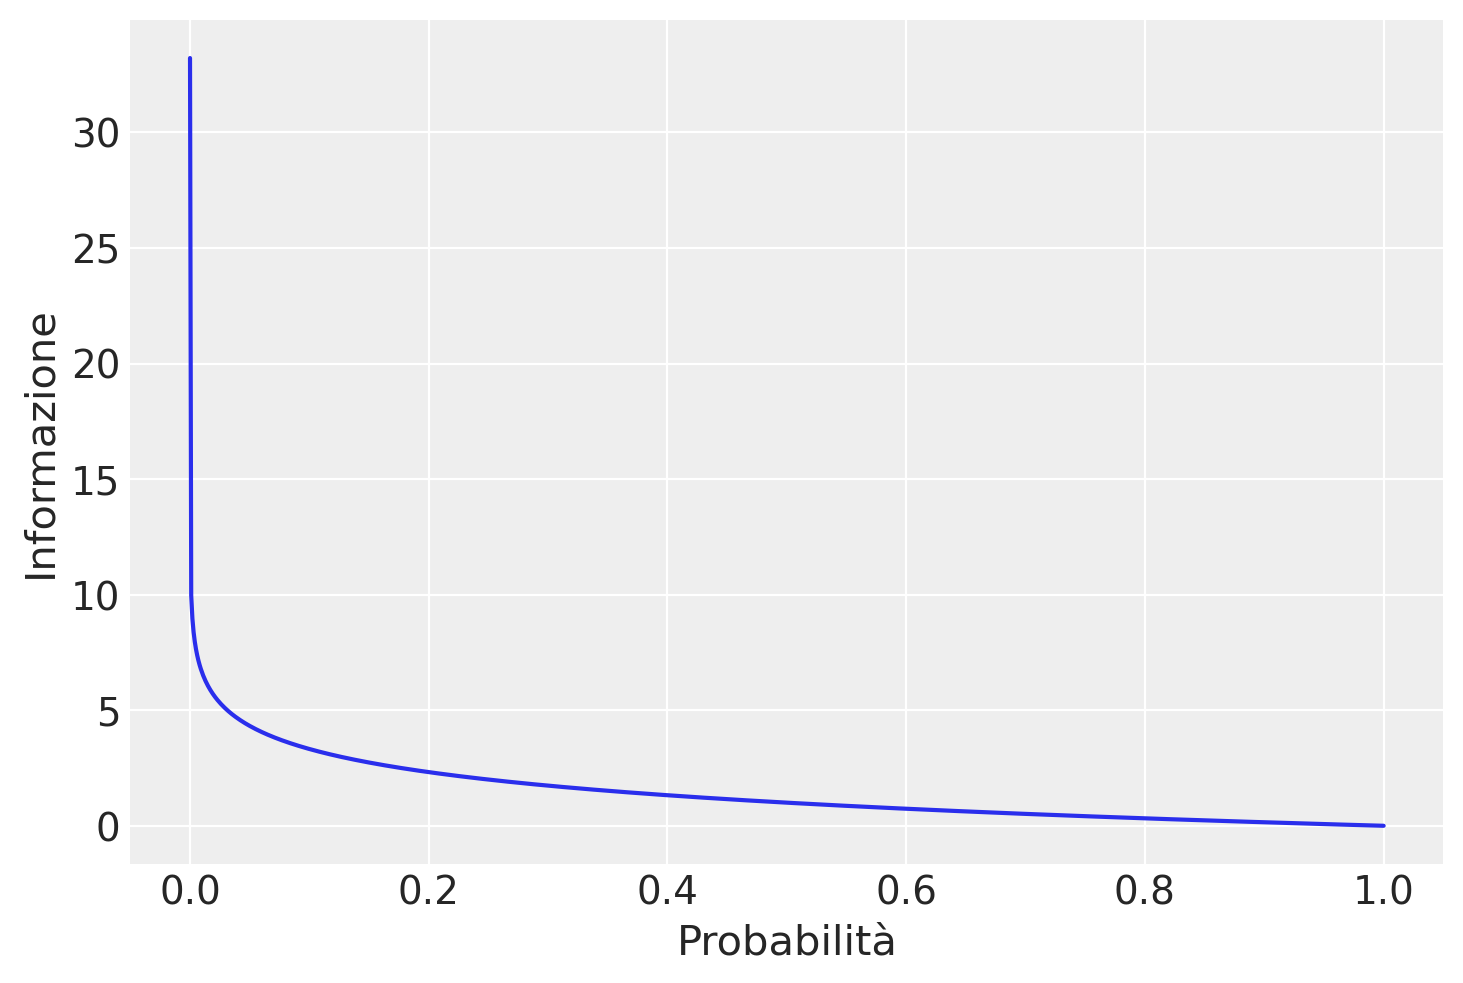

In [7]:
# Create a sequence of 1000 equally spaced points from 0 to 1
p = np.linspace(0, 1, 1000)

# Avoid log(0) by replacing 0 with a small value
p[p == 0] = 1e-10

# Compute the negative log base 2 of p
h = -np.log2(p)

df = pd.DataFrame({'Probabilità': p, 'Informazione': h})

plt.plot('Probabilità', 'Informazione', data=df)
plt.xlabel('Probabilità')
plt.ylabel('Informazione');

La figura mostra che questa relazione non è lineare, è infatti leggermente sublineare. Questo ha senso dato che abbiamo usato una funzione logaritmica.

#### Entropia e Varianza di una Distribuzione

È comune pensare che l'entropia e la varianza di una distribuzione siano collegate in modo tale che, all'aumentare della varianza, aumenti anche l'entropia. Tuttavia, la relazione tra queste due misure non è così diretta e può variare a seconda delle caratteristiche specifiche delle distribuzioni.

Consideriamo, per esempio, il caso di distribuzioni normali con diversi valori di varianza. In Python, possiamo calcolare l'entropia di queste distribuzioni come segue:

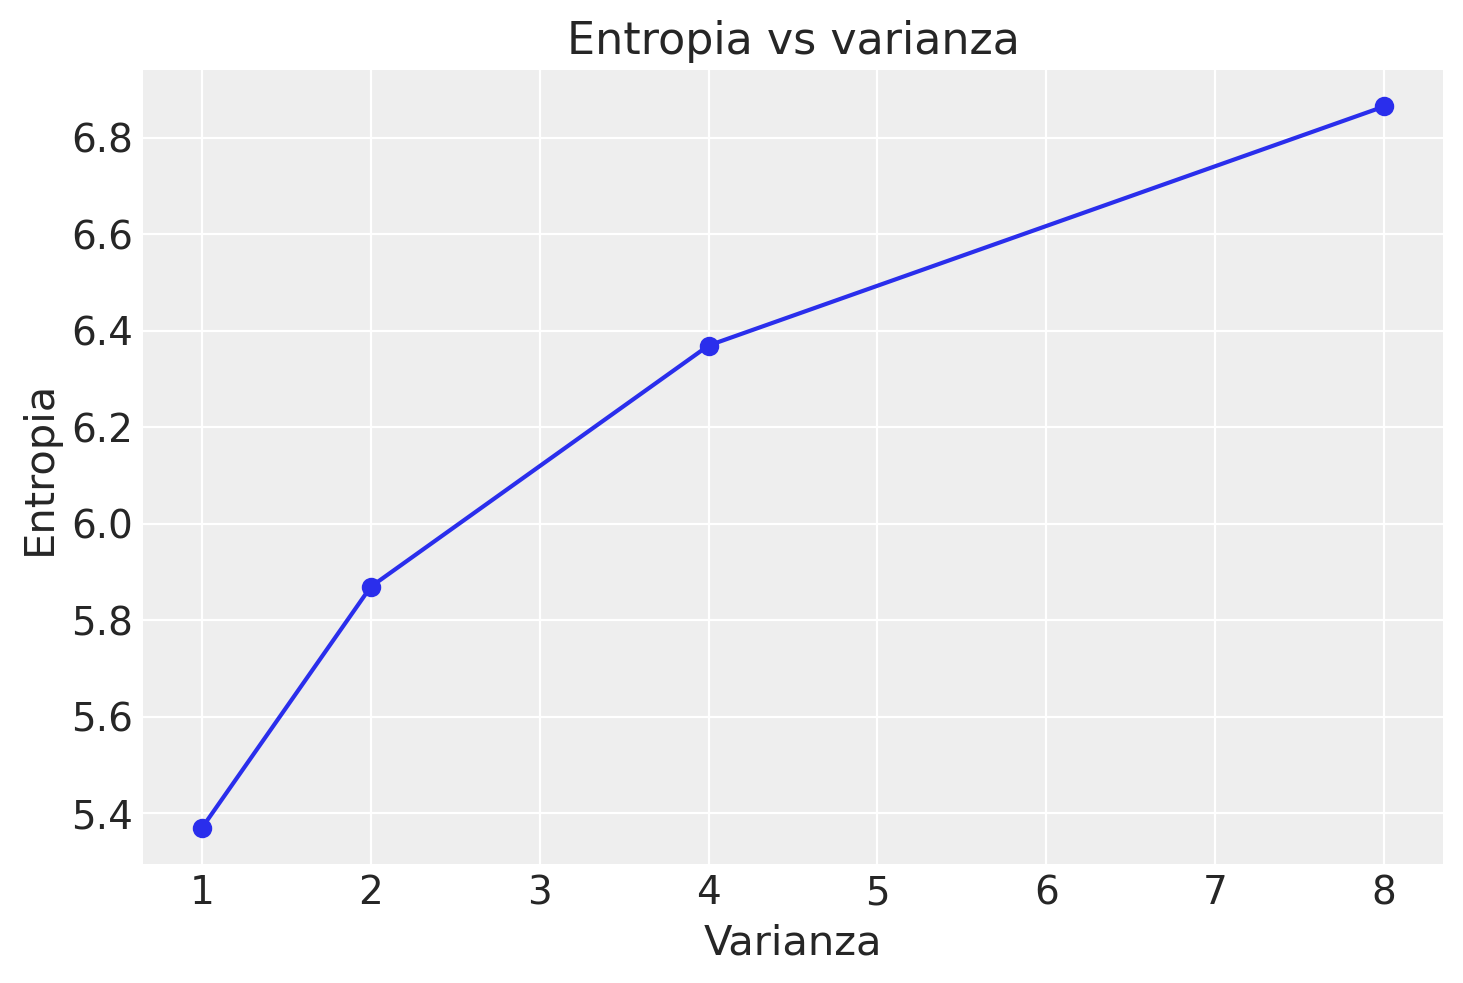

In [8]:
# Intervallo di valori discreti
x = np.arange(-10, 10, 0.1)

def calculate_entropy(variance):
    # Distribuzione normale con media 0 e varianza specifica
    probabilities = stats.norm.pdf(x, 0, np.sqrt(variance))
    
    # Normalizzazione delle probabilità in modo che sommino a 1
    probabilities /= probabilities.sum()
    
    # Calcolo dell'entropia
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Varianze da esplorare
variances = [1, 2, 4, 8]

# Calcolo e tracciamento dell'entropia per diverse varianze
entropies = [calculate_entropy(variance) for variance in variances]

plt.plot(variances, entropies, marker='o')
plt.title('Entropia vs varianza')
plt.xlabel('Varianza')
plt.ylabel('Entropia');

Questo script mostra che, per la distribuzione normale, l'entropia tende ad aumentare con l'aumento della varianza. Tuttavia, consideriamo ora due distribuzioni con la stessa varianza ma probabilità differenti:

In [9]:
def calculate_entropy(probabilities):
    return -np.sum(probabilities * np.log2(probabilities))

# Distribuzioni con la stessa varianza ma diverse probabilità
probabilities1 = np.array([0.5, 0.25, 0.25])
probabilities2 = np.array([0.3333, 0.3333, 0.3334])

# Calcolo dell'entropia per entrambe le distribuzioni
entropy1 = calculate_entropy(probabilities1)
entropy2 = calculate_entropy(probabilities2)

print(f"Entropia della distribuzione 1: {entropy1}")
print(f"Entropia della distribuzione 2: {entropy2}")

Entropia della distribuzione 1: 1.5
Entropia della distribuzione 2: 1.5849624862946867


Questo esempio dimostra che due distribuzioni con la stessa varianza possono avere entropie differenti, a seconda della configurazione delle loro probabilità.

In sintesi:

- *Varianza:* Misura la dispersione dei dati intorno alla loro media. Quantifica quanto i valori si discostano dalla media, ma non considera la probabilità di ciascun valore.
- *Entropia:* Valuta l'incertezza nella distribuzione di probabilità. Considera la probabilità di ogni possibile esito, quantificando l'incertezza media nell'osservazione di un esito casuale.

Pertanto, distribuzioni con la stessa varianza possono avere entropie differenti e viceversa. Questo dipende da come sono distribuite le probabilità all'interno della distribuzione. La varianza e l'entropia sono, quindi, indicatori complementari dell'incertezza in una distribuzione di dati, ma esplorano questa incertezza da prospettive diverse.

### Esercizio sulla Divergenza di Kullback-Leibler in un Contesto di Esame

Immaginatevi in un contesto di esame a scelta multipla, dove, invece di selezionare una sola risposta per domanda, dovete assegnare una probabilità di correttezza a ciascuna delle opzioni. Il vostro punteggio per ogni domanda sarà calcolato usando il logaritmo della probabilità assegnata all'opzione corretta. Se la risposta giusta è $A_i$, il vostro punteggio per quella domanda sarà $\log(p_i)$, dove $p_i$ è la probabilità che avete attribuito a $A_i$.

In questo sistema di punteggio, il massimo che potete ottenere per una singola domanda è 0 (assegnando una probabilità del 100% alla risposta corretta), mentre il punteggio minimo è $-\infty$ se assegnate una probabilità di zero alla risposta corretta. Il vostro obiettivo finale è massimizzare il punteggio atteso per l'intero esame.

Dato che non conoscete a priori la risposta corretta a ogni domanda, diventa cruciale utilizzare le vostre "migliori stime personali" delle probabilità. Supponiamo che queste stime siano rappresentate dal vettore $p = [p_1, p_2, \ldots, p_n]$.

Il punteggio atteso, basato su queste stime personali, è dato da:

$$
\text{Punteggio atteso con } p = \sum_{i=1}^{n} p_i \log(p_i).
$$

Considerando l'idea di utilizzare un set alternativo di probabilità $q = [q_1, q_2, \ldots, q_n]$, il punteggio atteso cambierebbe a:

$$
\text{Punteggio atteso con } q = \sum_{i=1}^{n} p_i \log(q_i).
$$

La divergenza di Kullback-Leibler (KL) tra i due set di probabilità $p$ e $q$ è calcolata come:

$$
\Delta = D_{KL}(p \parallel q) = \sum_{i=1}^{n} p_i \log\left(\frac{p_i}{q_i}\right).
$$

Questa divergenza KL, sempre non negativa, misura la differenza tra le stime $p$ e $q$. Si annulla solo se $p = q$, indicando che il punteggio atteso è massimizzato quando si utilizzano le stime personali più accurate, $p$.

In questo scenario, quindi, l'approccio ottimale è utilizzare stime basate sulle informazioni a disposizione. Qualsiasi manipolazione delle stime senza giustificazione basata su nuove informazioni riduce il punteggio atteso. Le vostre migliori stime personali rappresentano la comprensione più accurata che avete del problema. Deviare da queste stime senza validi motivi equivale a compromettere le vostre possibilità di successo.

Inoltre, nel sistema di punteggio basato sul logaritmo delle probabilità, non esiste alcun vantaggio nel tentare di "ingannare" il sistema; ogni tentativo di manipolazione si traduce in una penalizzazione del punteggio atteso. Questo allinea perfettamente con i principi della teoria delle decisioni bayesiane, che premia la trasparenza e l'accuratezza nelle stime probabilistiche.

Nella seguente simulazione abbiamo due gruppi di studenti che rispondono a un esame a scelta multipla di sei domande, ognuna con cinque alternative di risposta. Per il gruppo di studenti "onesti", abbiamo impostato che nel 75% dei casi assegnano la probabilità più alta alla risposta corretta. Per il gruppo di studenti che "imbrogliano", abbiamo assunto che riescano a indovinare la risposta corretta nel 60% dei casi, ma assegnano le probabilità in modo distorto.

In [14]:
# Numero di studenti per gruppo
num_studenti = 100
num_domande = 6
num_alternative = 5

# Funzione per calcolare il punteggio atteso usando la metrica del logaritmo delle probabilità
def calcola_punteggio(probabilita):
    return np.sum(probabilita * np.log(probabilita), axis=2)

# Creazione di risposte per il gruppo di studenti onesti (75% di risposte corrette)
p_onesti = np.full((num_studenti, num_domande, num_alternative), 1 / num_alternative)
for studente in range(num_studenti):
    for domanda in range(num_domande):
        if (
            np.random.rand() < 0.75
        ):  # 75% di possibilità di scegliere la risposta corretta
            risposta_corretta = np.random.randint(num_alternative)
            p_onesti[
                studente, domanda, :
            ] = 0.1  # probabilità di base per le risposte sbagliate
            p_onesti[
                studente, domanda, risposta_corretta
            ] = 0.6  # probabilità più alta per la risposta corretta
        # Altrimenti lascia le probabilità uguali (caso in cui la risposta è sbagliata)

# Creazione di risposte per il gruppo di studenti che "imbrogliano" (60% di risposte corrette)
p_imbrogli = np.random.rand(num_studenti, num_domande, num_alternative)
for studente in range(num_studenti):
    for domanda in range(num_domande):
        if (
            np.random.rand() < 0.60
        ):  # 60% di possibilità di scegliere la risposta corretta
            risposta_corretta = np.random.randint(num_alternative)
            p_imbrogli[
                studente, domanda, risposta_corretta
            ] += 5  # aumentare la probabilità per la risposta corretta
        # Distribuzione distorta di probabilità
        p_imbrogli[studente, domanda, :] /= p_imbrogli[studente, domanda, :].sum()

# Calcolo del punteggio atteso per i due gruppi di soggetti
punteggio_onesti = calcola_punteggio(p_onesti)
punteggio_imbrogli = calcola_punteggio(p_imbrogli)

# Calcolo della differenza media dei punteggi tra i due gruppi
differenza_media_onesti_imbrogli = np.mean(punteggio_onesti - punteggio_imbrogli)

differenza_media_onesti_imbrogli

-0.204028573142205

La differenza media dei punteggi attesi tra i due gruppi, calcolata usando la metrica del logaritmo delle probabilità, è di circa -0.2. Questo risultato suggerisce che, in media, i soggetti che "imbrogliano" (assegnando le probabilità in modo distorto) hanno ottenuto punteggi attesi inferiori rispetto a quelli che hanno assegnato le probabilità in modo più accurato e onesto.

Questo dimostra che, nel contesto di questo esame a scelta multipla, un approccio accurato e onesto nella stima delle probabilità porta a un punteggio atteso più alto, mentre la manipolazione delle stime probabilistiche senza basi informative solide porta a una penalizzazione nel punteggio atteso.​

Calcoliamo ora la divergenza di Kullback-Leibler (KL). 

In [15]:
# Calcolo della divergenza di Kullback-Leibler tra i due gruppi di studenti

def calcola_divergenza_kl(p, q):
    return np.sum(p * np.log(p / q), axis=2)

# Calcolo della divergenza KL per ogni studente e ogni domanda
divergenza_kl = calcola_divergenza_kl(p_onesti, p_imbrogli)

# Calcolo della media della divergenza KL tra tutti gli studenti
media_divergenza_kl = np.mean(divergenza_kl)

media_divergenza_kl

0.8736327720192857

La divergenza di KL media calcolata tra i due gruppi di studenti è di circa 0.9.

Nel contesto dell'esercizio, la divergenza KL misura la differenza, su scala logaritmica, tra due approcci di stima delle probabilità rispetto a una distribuzione di probabilità "vera" (che idealmente assegna una probabilità di 1 alla risposta corretta e 0 a tutte le altre).

La divergenza KL di circa 0.9 indica quanto la stima media fornita dal gruppo che "imbroglia" sia più distante dalla distribuzione vera rispetto alla stima media fornita dal gruppo "onesto". In altre parole, un valore di divergenza KL di circa 0.9 indica che le stime dei rispondenti che "imbrogliano" sono in media più lontane dalla distribuzione vera rispetto a quelle dei rispondenti "onesti".


## Riflessioni Conclusive e Prospettive Future

Nel corso di questo capitolo, abbiamo intrapreso un viaggio attraverso il concetto di entropia, esplorandone l'importanza come strumento per quantificare l'incertezza all'interno di una distribuzione di probabilità. Questa esplorazione ci ha permesso di comprendere come l'entropia non sia semplicemente una misura di incertezza, ma anche una lente attraverso cui possiamo osservare e interpretare la natura probabilistica dei fenomeni.

Una domanda naturale che potrebbe emergere a questo punto è: come possiamo sfruttare l'entropia per valutare la "distanza" tra un modello teorico e la realtà effettiva dei dati? È qui che entra in gioco la divergenza di Kullback-Leibler, un concetto che abbiamo solo accennato ma che riveste un'importanza fondamentale. La divergenza KL non è solo uno strumento per misurare le discrepanze tra due distribuzioni probabilistiche, ma rappresenta anche un ponte concettuale tra la teoria e la pratica, tra il modello ideale e il mondo empirico.

Nel prossimo capitolo, ci immergeremo più profondamente nel mondo della divergenza di Kullback-Leibler. Esploreremo come questo strumento possa essere utilizzato per confrontare modelli teorici con dati empirici, e come possa aiutarci a comprendere meglio il grado di aderenza di un modello alla realtà che cerca di rappresentare. Inoltre, discuteremo delle implicazioni pratiche della divergenza KL in vari ambiti, dalla selezione del modello all'ottimizzazione delle stime probabilistiche, evidenziando come questa misura possa essere applicata in situazioni concrete di analisi dei dati.

In conclusione, la nostra esplorazione dell'entropia e della divergenza KL ci guida verso una comprensione più profonda non solo della teoria della probabilità, ma anche di come queste misure si rivelino strumenti vitali nel campo della statistica e della ricerca scientifica. 

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Nov 15 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

matplotlib : 3.8.1
arviz      : 0.16.1
scipy      : 1.11.3
seaborn    : 0.13.0
statsmodels: 0.14.0
numpy      : 1.25.2
pandas     : 2.1.3

Watermark: 2.4.3

